**데이터 불러오기**

**google과 naver에서 크롤링한 이미지를 압축시켜 google drive에 저장하였습니다.**

In [ ]:
#구글 드라이브와 연동시킵니다.
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


**필요 패키지 import, image feature vector model (Pre-Trained된 모형) 불러오기**


In [ ]:
import urllib.request
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt
import itertools
import os
import pandas as pd

In [ ]:
feature_extractor_url = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1" #모형링크
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3), trainable=False) #inputshape, train가능여부 지정

**이미지파일 전처리 함수**

In [ ]:
def decoding(image_path):
    image_bytes = tf.io.gfile.GFile(image_path, 'rb').read() #이미지를 읽습니다
    target_image = tf.constant(image_bytes, dtype=tf.string)
    image = tf.image.decode_image(target_image, channels=3) #decoding
    image = tf.image.resize( 
        image, [224, 224]) #이미지 사이즈를 변경합니다(모형 input_size에 맞춰 변경)
    image = tf.squeeze(image) #차원을 낮춥니다
    image = tf.cast(image, dtype=tf.uint8) 
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) #정규화 및 dtype을 변경합니다
    image = tf.expand_dims(image, 0) #차원을 한단계 추가합니다 (224,224,3) > (1,224,224,3)
    return image

**Sample - 데이터 로드**

In [ ]:
fantasy_zip = zipfile.ZipFile('/content/gdrive/My Drive/meals.zip') #압축되어 있는 파일을 풀어줍니다.
fantasy_zip.extractall('/content/gdrive/My Drive/') #압축을 푼 파일을 두는 장소입니다.
fantasy_zip.close()

In [ ]:
path = '/content/gdrive/My Drive/meals'
#이미지 파일명 리스트
file_list = os.listdir(path)

**Sample - Target 이미지 전처리 및 feature 추출**

In [ ]:
target = file_list[0] #타켓이미지 파일을 정합니다.
target_image_path = '/content/gdrive/My Drive/meals/'+target #이미지 위치
target_image = decoding(target_image_path)
target_feature = feature_extractor_layer(target_image) #이미지 feature 추출
print(target_feature.shape) #(1, 2048)

(1, 2048)


**Sample - Target 이미지**

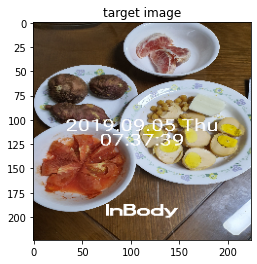

In [ ]:
plt.imshow(tf.squeeze(target_image, 0))
plt.title("target image")
plt.show()

**Sample - Input 이미지 (Target 외 이미지) 전처리 및 feature 추출**

In [ ]:
file_list.remove(target) #타겟이미지 명을 제거 합니다.
input_image = [] #시각화를 위해 값을 저장합니다.
input_image_feature = [] 
for i in range(len(file_list)):
    image_path = '/content/gdrive/My Drive/meals/'+file_list[i] #이미지 파일의 path입니다.
    image = decoding(image_path)
    input_image.append(image)
    input_image_feature.append(feature_extractor_layer(image))

In [ ]:
#형식 변경 및 shape확인
input_image_feature=np.array(input_image_feature) #list를 array로 바꿉니다.
input_image_feature.shape #shape을 확인합니다.

(4, 1, 2048)

**Sample - Cosine 유사도 및 유클리드 거리 계산**

In [ ]:
cosine_similarities = [] #시각화를 위해 유사도 값을 저장합니다.
Euclidean_distances = []
for i in range(len(file_list)):
    dot = tf.tensordot(target_feature, tf.transpose(input_image_feature[i]), 1) #내적 값을 계산합니다.
    
    #코사인 유사도
    cosine_similarity = dot / (tf.norm(target_feature, axis=1) * tf.norm(input_image_feature[i], axis=1))
    cosine_similarity = tf.reshape(cosine_similarity, [-1])
    cosine_similarities.append(float(cosine_similarity))

    #유클리드 거리
    Euclidean = 2*(1-float(cosine_similarity))
    Euclidean_distances.append(Euclidean)

**Sample_시각화 - Cosin 유사도**

In [ ]:
input_data = pd.DataFrame()
input_data['cosine_similarities'] = cosine_similarities
input_data['Euclidean_distances'] = Euclidean_distances
input_data['input_image'] = input_image
input_data=input_data.sort_values(by=['cosine_similarities'], ascending=False) #유사도가 높은 순으로 시각화하기 위해 정렬합니다.

,cosine_similarities,Euclidean_distances,input_image
0,0.874203,0.251593,(((tf.Tensor([0.38823533 0.26666668 0.15294118...
1,0.828074,0.343851,(((tf.Tensor([0.26666668 0.20000002 0.12156864...
2,0.757040,0.485921,(((tf.Tensor([0.69803923 0.7019608 0.6862745 ...
3,0.733214,0.533573,(((tf.Tensor([0.01176471 0.00392157 0.01568628...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


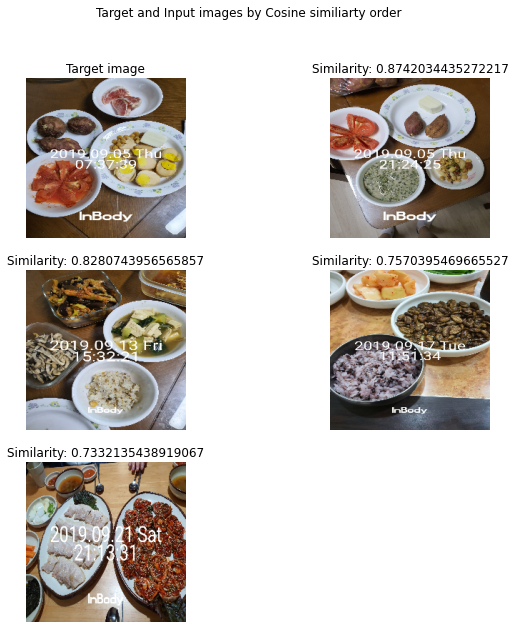

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.2)

from_top=input_data['cosine_similarities'][0:4].index

for i in range(len(cosine_similarities)):
    plt.subplot(3,2,1)
    plt.imshow(tf.squeeze(target_image, 0))
    plt.title("Target image")
    plt.axis('off')

    plt.subplot(3,2,i+2)
    plt.imshow(tf.squeeze(input_data['input_image'][from_top[i]], 0))
    plt.title("Similarity: "  + str(input_data['cosine_similarities'][from_top[i]]))
    plt.axis('off')
    _ = plt.suptitle("Target and Input images by Cosine similiarty order")

**Sample_시각화 - 유클리드 거리**

In [ ]:
input_data = input_data.sort_values(by=['Euclidean_distances'], axis=0, ascending=True)#거리가 작은 순으로 시각화하기 위해 정렬합니다.

,cosine_similarities,Euclidean_distances,input_image
0,0.874203,0.251593,(((tf.Tensor([0.38823533 0.26666668 0.15294118...
1,0.828074,0.343851,(((tf.Tensor([0.26666668 0.20000002 0.12156864...
2,0.757040,0.485921,(((tf.Tensor([0.69803923 0.7019608 0.6862745 ...
3,0.733214,0.533573,(((tf.Tensor([0.01176471 0.00392157 0.01568628...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


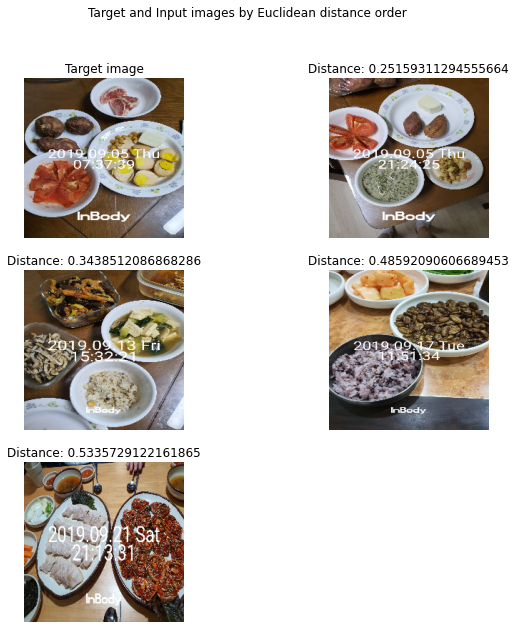

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.2)

from_top=input_data['cosine_similarities'][0:4].index

for i in range(len(Euclidean_distances)):
    plt.subplot(3,2,1)
    plt.imshow(tf.squeeze(target_image, 0))
    plt.title("Target image")
    plt.axis('off')

    plt.subplot(3,2,i+2)
    plt.imshow(tf.squeeze(input_data['input_image'][from_top[i]], 0))
    plt.title("Distance: "  + str(input_data['Euclidean_distances'][from_top[i]]))
    plt.axis('off')
    _ = plt.suptitle("Target and Input images by Euclidean distance order")

**모든 식단 이미지로 부터 유사도 측정**

**데이터 로드**


In [ ]:
fantasy_zip2 = zipfile.ZipFile('/content/gdrive/My Drive/meals2.zip') #압축되어 있는 파일을 풀어줍니다.
fantasy_zip2.extractall('/content/gdrive/My Drive/') #압축을 푼 파일을 두는 장소입니다.
fantasy_zip2.close()

In [ ]:
path = '/content/gdrive/My Drive/meals2'
#이미지 파일명 리스트
file_list = os.listdir(path)

**이미지 확인**


In [ ]:
target = file_list[7] #타켓이미지 파일을 정합니다.
target_image_path = '/content/gdrive/My Drive/meals2/'+target #이미지 위치
target_image = decoding(target_image_path)
target_feature = feature_extractor_layer(target_image) #이미지 feature 추출
print(target_feature.shape) #(1, 2048)

(1, 2048)


**Target 이미지**

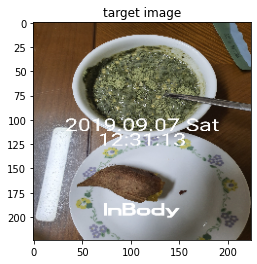

In [ ]:
plt.imshow(tf.squeeze(target_image, 0))
plt.title("target image")
plt.show()

**Input 이미지 (Target 외 이미지) 전처리 및 feature 추출**

In [ ]:
file_list.remove(target) #타겟이미지 명을 제거 합니다.
input_image = [] #시각화를 위해 값을 저장합니다.
input_image_feature = [] 
for i in range(len(file_list)):
    image_path = '/content/gdrive/My Drive/meals2/'+file_list[i] #이미지 파일의 path입니다.
    image = decoding(image_path)
    input_image.append(image)
    input_image_feature.append(feature_extractor_layer(image))

In [ ]:
#형식 변경 및 shape확인
input_image_feature=np.array(input_image_feature) #list를 array로 바꿉니다.
input_image_feature.shape #shape을 확인합니다.

(75, 1, 2048)

**Sample - Cosine 유사도 및 유클리드 거리 계산**

In [ ]:
cosine_similarities = [] #시각화를 위해 유사도 값을 저장합니다.
Euclidean_distances = []
for i in range(len(file_list)):
    dot = tf.tensordot(target_feature, tf.transpose(input_image_feature[i]), 1) #내적 값을 계산합니다.
    
    #코사인 유사도
    cosine_similarity = dot / (tf.norm(target_feature, axis=1) * tf.norm(input_image_feature[i], axis=1))
    cosine_similarity = tf.reshape(cosine_similarity, [-1])
    cosine_similarities.append(float(cosine_similarity))

    #유클리드 거리
    Euclidean = 2*(1-float(cosine_similarity))
    Euclidean_distances.append(Euclidean)

In [ ]:
input_data = pd.DataFrame()
input_data['cosine_similarities'] = cosine_similarities
input_data['Euclidean_distances'] = Euclidean_distances
input_data['input_image'] = input_image
input_data=input_data.sort_values(by=['cosine_similarities'], ascending=False) #유사도가 높은 순으로 시각화하기 위해 정렬합니다.

**시각화 - Cosin 유사도 (상위 9개, 하위9개)**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


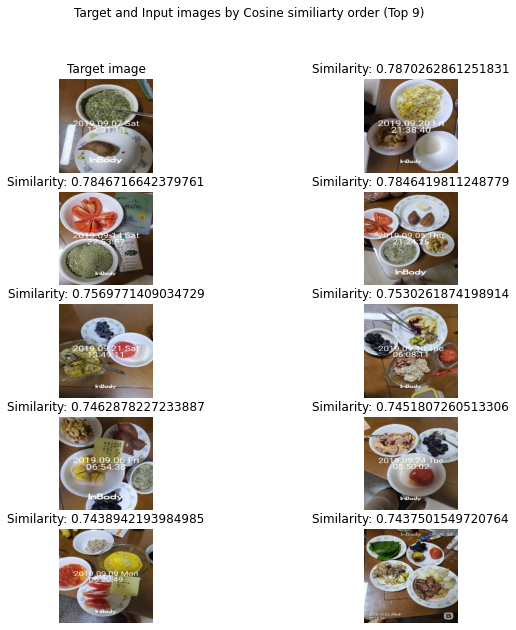

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.2)

top_nine=input_data['cosine_similarities'][0:9].index #상위 9개의 index값을 가져옵니다

for i in range(9):
    plt.subplot(5,2,1)
    plt.imshow(tf.squeeze(target_image, 0))
    plt.title("Target image")
    plt.axis('off')

    plt.subplot(5,2,i+2)
    plt.imshow(tf.squeeze(input_data['input_image'][top_nine[i]], 0))
    plt.title("Similarity: "  + str(input_data['cosine_similarities'][top_nine[i]]))
    plt.axis('off')
    _ = plt.suptitle("Target and Input images by Cosine similiarty order (Top 9)")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


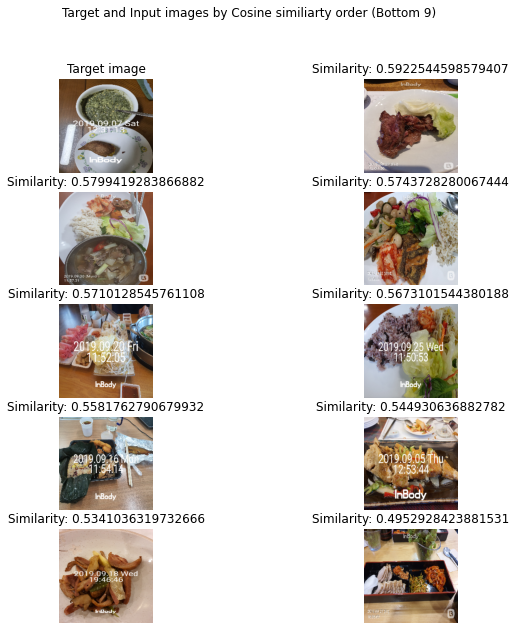

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.2)

bottom_nine=input_data['cosine_similarities'][-9:].index #하위 9개의 index값을 가져옵니다

for i in range(9):
    plt.subplot(5,2,1)
    plt.imshow(tf.squeeze(target_image, 0))
    plt.title("Target image")
    plt.axis('off')

    plt.subplot(5,2,i+2)
    plt.imshow(tf.squeeze(input_data['input_image'][bottom_nine[i]], 0))
    plt.title("Similarity: "  + str(input_data['cosine_similarities'][bottom_nine[i]]))
    plt.axis('off')
    _ = plt.suptitle("Target and Input images by Cosine similiarty order (Bottom 9)")

**시각화 - 유클리드 거리 (상위 9개, 하위9개)**

In [ ]:
input_data = input_data.sort_values(by=['Euclidean_distances'], axis=0, ascending=True)#거리가 작은 순으로 시각화하기 위해 정렬합니다

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


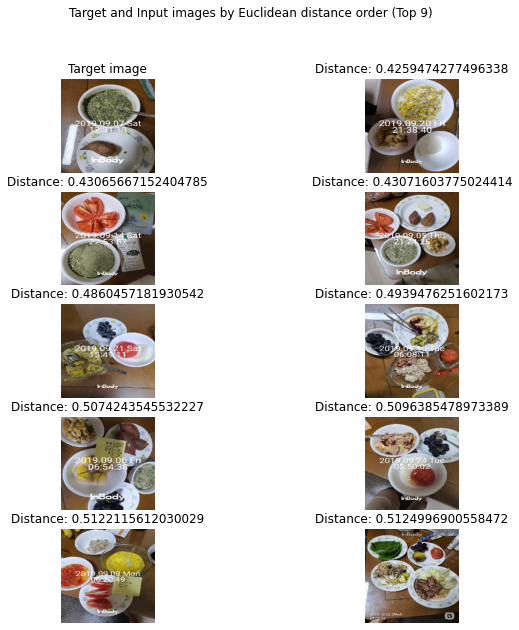

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.2)

top_nine=input_data['cosine_similarities'][0:9].index

for i in range(9):
    plt.subplot(5,2,1)
    plt.imshow(tf.squeeze(target_image, 0))
    plt.title("Target image")
    plt.axis('off')

    plt.subplot(5,2,i+2)
    plt.imshow(tf.squeeze(input_data['input_image'][top_nine[i]], 0))
    plt.title("Distance: "  + str(input_data['Euclidean_distances'][top_nine[i]]))
    plt.axis('off')
    _ = plt.suptitle("Target and Input images by Euclidean distance order (Top 9)")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


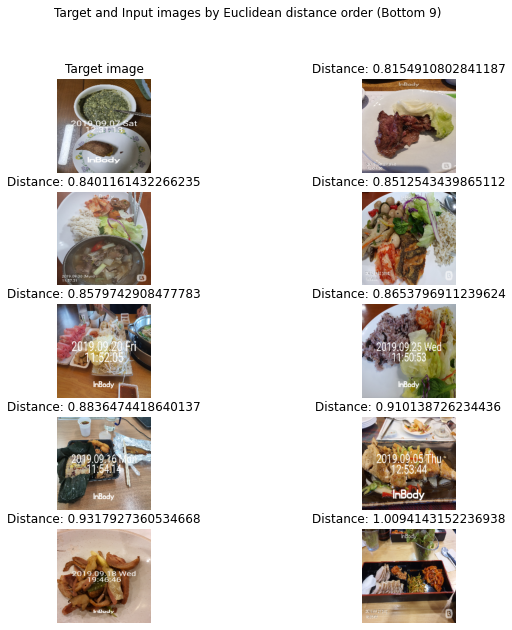

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.2)

bottom_nine=input_data['cosine_similarities'][-9:].index

for i in range(9):
    plt.subplot(5,2,1)
    plt.imshow(tf.squeeze(target_image, 0))
    plt.title("Target image")
    plt.axis('off')

    plt.subplot(5,2,i+2)
    plt.imshow(tf.squeeze(input_data['input_image'][bottom_nine[i]], 0))
    plt.title("Distance: "  + str(input_data['Euclidean_distances'][bottom_nine[i]]))
    plt.axis('off')
    _ = plt.suptitle("Target and Input images by Euclidean distance order (Bottom 9)")